In [1]:
# Connect to drive to get dataset

from google.colab import drive
drive.mount("/content/drive")

# Unzip data if loaded from drive
!unzip -q "/content/drive/My Drive/Coins Detector - Keras/br-coins-classification.zip" -d "/content/sample_data/br-coins-classification"

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.
# Use Kaggle API to download datase from Kaggle

# from google.colab import files
# files.upload() #upload kaggle.json

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

# !kaggle kernels list — user YOUR_USER — sort-by dateRun

# !kaggle datasets download -d lgmoneda/br-coins

# !unzip -q br-coins.zip -d br-coins-dataset
# !ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Imports

# Read datas from dataset and make X & Y
import os
import cv2
import scipy
from google.colab.patches import cv2_imshow

# Split data into train & test
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import numpy as np

# Plot images
import matplotlib.pyplot as plt

# Data augmentation
from keras.preprocessing.image import ImageDataGenerator

# Create keras sequential classifier model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Compile the model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

from keras.utils.vis_utils import plot_model

In [3]:
# Set parameters

# prepare data parameters
train_size = 0.8
test_size = 0.2

# create model parameters
num_of_classes = 5
epochs = 100
batch_size = 128
data_augmentation = True
load_weights = False

In [4]:
# Data preparation

# Crop the coin out of whole image
def crop_image(img_complete_path):
  # load the image, clone it for output, and then convert it to grayscale
  image = cv2.imread(img_complete_path)
  # output = image.copy()
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # detect circles in the image
  circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 8, 700)
  # ensure at least some circles were found
  if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
    # print(circles)      # circles = (x, y, radius) from top-left
    circles[0, 2] += 35   # make the circle a bit larger to contain the whole coin
    # print(circles)

    # crop the circle in the image
    y_line_1 = circles[0, 0] - circles[0, 2]
    if y_line_1 < 0:
      y_line_1 = 0
    y_line_2 = circles[0, 0] + circles[0, 2]
    x_line_1 = circles[0, 1] - circles[0, 2]
    if x_line_1 < 0:
      x_line_1 = 0
    x_line_2 = circles[0, 1] + circles[0, 2]
    # print(y_line_1)
    # print(y_line_2)
    # print(x_line_1)
    # print(x_line_2)
    cropped = image[x_line_1:x_line_2, y_line_1:y_line_2]
    return cropped
  # else:
  #   print("Could not find coin.")

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

# Fetch data from unzipped dataset and create X and Y
# cents = [5, 10, 25, 50, 100]
# index = [0, 1, 2, 3, 4]
def fetch_data_from_dataset():
  X = []
  Y = []

  path = "/content/sample_data/br-coins-classification/all"
  pics_names = os.listdir("/content/sample_data/br-coins-classification/all")\

  print("Fetching data from unzipped dataset.")
  for i in range(len(pics_names)):
    pic_name_i = pics_names[i]
    pic_complete_path = os.path.join(path, pic_name_i)
    # new_x = cv2.imread(pic_complete_path)
    new_x = crop_image(pic_complete_path)
    if new_x is None:
      # print(pic_complete_path)
      new_x = cv2.imread(pic_complete_path)
    new_new_x = cv2.resize(new_x, (128, 128))
    # print(new_new_x.shape)
    # print(pic_complete_path)
    # print("~~~~~~~~~~~~~~~~")
    X.append(new_new_x)
    new_y = str.split(pic_name_i, '_')
    if new_y[0]=='100':
      Y.append(4)
    if new_y[0]=='50':
      Y.append(3)
    if new_y[0]=='25':
      Y.append(2)
    if new_y[0]=='10':
      Y.append(1)
    if new_y[0]=='5':
      Y.append(0)

  print("Number of samples: ", len(pics_names), "\n")

  return X, Y

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

# split X, Y data into train/test using scikit lear library
def train_test_split_data(X, Y, train_size, test_size):
  print("Splitting dataset into train & test, train_size: ", train_size, " , test_size: ", test_size, "\n")
  X = np.array(X)
  Y = np_utils.to_categorical(Y, 5)
  x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                      train_size=train_size,
                                                      test_size=test_size,
                                                      random_state=122,
                                                      shuffle=True)

  # Normalize data
  # x_train = np.array(x_train)
  # x_test = np.array(x_test)
  # x_train = x_train.astype('float32')
  # x_test = x_test.astype('float32')
  # x_train = x_train/255.
  # x_test = x_test/255.

  print("x_train shape : ", x_train.shape)
  print("y_train shape : ", y_train.shape)
  print("x_test shape : ", x_test.shape)
  print("y_test shape : ", y_test.shape, "\n")

  # Free memory
  # !rm -rf "/content/sample_data/br-coins-classification"
  # print("Delete the br-coins-classification unzipped folder.\n")
  del X
  del Y
  print("Free X and Y memory.\n")

  return x_train, y_train, x_test, y_test

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

# Create data generator
def create_data_generator():
  print("Data augmentating.")
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
      featurewise_center=False,  # set input mean to 0 over the dataset
      samplewise_center=False,  # set each sample mean to 0
      featurewise_std_normalization=False,  # divide inputs by std of the dataset
      samplewise_std_normalization=False,  # divide each input by its std
      zca_whitening=False,  # apply ZCA whitening
      rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
      width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
      height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
      horizontal_flip=True,  # randomly flip images
      vertical_flip=False)  # randomly flip images

  datagen.fit(x_train)
  return datagen

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

In [5]:
# Model Preparation

def create_classifier(num_of_classes, load_weights, load_path="/content/drive/My Drive/Coins Detector - Keras/Brazilian_coins_detector_weights.h5"):
  # Create model
  classifier = Sequential()
  
  classifier.add(Conv2D(32, (5, 5), input_shape=(128, 128, 3), padding="same", activation='relu'))
  classifier.add(MaxPooling2D(pool_size=(2, 2)))
  
  classifier.add(Conv2D(64, (3, 3), input_shape=(128, 128, 3), padding="same", activation='relu'))
  classifier.add(MaxPooling2D(pool_size=(2, 2)))

  classifier.add(Conv2D(128, (3, 3), input_shape=(128, 128, 3), padding="same", activation='relu'))
  classifier.add(MaxPooling2D(pool_size=(2, 2)))

  classifier.add(Conv2D(128, (3, 3), input_shape=(128, 128, 3), padding="same", activation='relu'))
  classifier.add(MaxPooling2D(pool_size=(2, 2)))

  classifier.add(Dropout(rate=0.2))
  
  # Flatten layer
  classifier.add(Flatten())
  
  # Dense layer
  classifier.add(Dense(128, activation='relu'))

  # Last layer must have 5 units since there are 5 classes
  # activation : softmax
  classifier.add(Dense(num_of_classes, activation='softmax'))

  # Compile model
  if load_weights:
    # Load previous weights
    classifier.load_weights(load_path)
  
  return classifier

def compile_classifier(classifier, x_train, y_train, datagen, data_augmentation, batch_size, epochs):
  # Compile the model
  classifier.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

  # Fit the model
  if not data_augmentation:
      print('Not using data augmentation.\n')
      network_history = classifier.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)
  else:
    print('Using real-time data augmentation.\n')
    # datagen.fit(x_train)
    network_history = classifier.fit(datagen.flow(x_train, y_train, batch_size=batch_size), steps_per_epoch=len(x_train)//batch_size, epochs=epochs, shuffle=True)

  print("\n~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.\n")

  return classifier, network_history

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

def test_classifier(classifier, x_test, y_test):
  y_test_predict = classifier.predict(x_test)
  label_predict = np.argmax(y_test_predict, axis=1)
  label_correct = np.argmax(y_test, axis=1)

  acc = 0
  for i in range(len(x_test)):
    # print(label_predict[i])
    # print(label_correct[i])
    # print("~~~~~~~~~~~~~~~~~")
    if label_predict[i] == label_correct[i]:
      acc += 1

  print("Acuuracy on x_test data: ", acc*100/len(x_test), "\n")
  return label_correct, label_predict

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

def show_classifier_plot_png(classifier, file_name='br-coins-detector.png'):
  plot_model(classifier)

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

def save_classifier_weights(save_path="/content/drive/My Drive/Coins Detector - Keras/Brazilian_coins_detector_weights.h5"):
  # classifier.save(save_path)
  classifier.save_weights(save_path)
  print("Weights saved.\n")

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

def save_classifier_model(save_path="/content/drive/My Drive/Coins Detector - Keras/Brazilian_coins_detector_model.h5"):
  classifier.save(save_path)
  print("Model saved.\n")

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

In [6]:
# Plots
import matplotlib.pyplot as plt

# plot_history function
def plot_history(net_history):
    history = net_history.history
    print(history.keys())

    acc = history['accuracy']
    # val_acc = history['val_accuracy']
    loss = history['loss']
    # val_loss = history['val_loss']
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    # plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    # plt.plot(val_acc)
    plt.legend(['acc', 'val_acc'])
    print("\n")

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

# Shows the 10-first images of x_test
def show_dataset():
  # create a grid of 3x3 x_train images
  for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
  # show the plot
  plt.show()
  print("\n")
  
# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

# Print y_test and y_predict_test of index=?
def show_pic(x_test, label_correct, label_predict, index):
  # plot the picture
  plt.figure()
  plt.imshow(x_test[index])
  plt.colorbar()
  plt.grid(False)
  plt.show()

  # print y_test[index]
  print("y_test: ", label_correct[index])

  # print y_test_predict[index]
  print("y_test_predict: ", label_predict[index], "\n")

# ~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.~.

Fetching data from unzipped dataset.
Number of samples:  3059 

Splitting dataset into train & test, train_size:  0.8  , test_size:  0.2 

x_train shape :  (2447, 128, 128, 3)
y_train shape :  (2447, 5)
x_test shape :  (612, 128, 128, 3)
y_test shape :  (612, 5) 

Free X and Y memory.



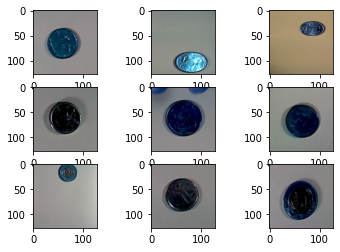



Data augmentating.


In [7]:
# ****************
# ** Main Block **
# ****************

# Prepare data
X, Y = fetch_data_from_dataset()
x_train, y_train, x_test, y_test = train_test_split_data(X, Y, train_size, test_size)

show_dataset()    # show 10-first images in x_train

datagen = create_data_generator()


Using real-time data augmentation.

Epoch 1/100
19/19 [==============================] - 9s 475ms/step - loss: 23.1370 - accuracy: 0.2204
Epoch 2/100
19/19 [==============================] - 9s 472ms/step - loss: 1.5673 - accuracy: 0.2777
Epoch 3/100
19/19 [==============================] - 9s 499ms/step - loss: 1.3858 - accuracy: 0.4179
Epoch 4/100
19/19 [==============================] - 9s 474ms/step - loss: 1.0847 - accuracy: 0.5455
Epoch 5/100
19/19 [==============================] - 9s 468ms/step - loss: 0.9314 - accuracy: 0.6296
Epoch 6/100
19/19 [==============================] - 9s 473ms/step - loss: 0.8689 - accuracy: 0.6524
Epoch 7/100
19/19 [==============================] - 9s 481ms/step - loss: 0.7752 - accuracy: 0.6925
Epoch 8/100
19/19 [==============================] - 9s 473ms/step - loss: 0.7940 - accuracy: 0.6887
Epoch 9/100
19/19 [==============================] - 9s 466ms/step - loss: 0.7392 - accuracy: 0.6999
Epoch 10/100
19/19 [==============================] - 

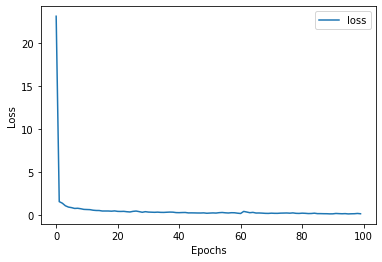

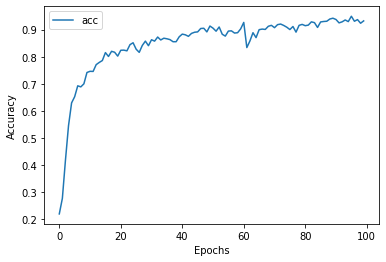

In [12]:
# Train model
classifier = create_classifier(num_of_classes, load_weights)

classifier, network_history = compile_classifier(classifier, x_train, y_train, datagen, data_augmentation, batch_size, epochs)
plot_history(network_history)

20/20 [==============================] - 0s 12ms/step - loss: 0.2723 - accuracy: 0.8938
Acuuracy on x_test data:  89.37908496732027 



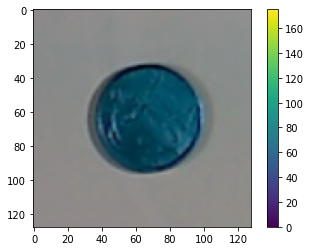

y_test:  1
y_test_predict:  1 



In [15]:
classifier.evaluate(x_test, y_test)
label_correct, label_predict = test_classifier(classifier, x_test, y_test)
show_pic(x_test, label_correct, label_predict, 4)

20/20 [==============================] - 0s 10ms/step - loss: 0.1269 - accuracy: 0.9510
Acuuracy on x_test data:  95.09803921568627 



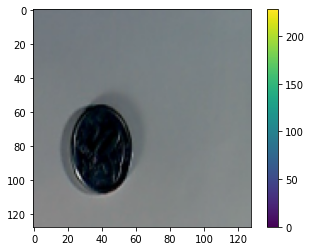

y_test:  3
y_test_predict:  3 



In [10]:
# Load weights and Test model
load_weights = True
classifier = create_classifier(num_of_classes, load_weights)

# Compile the model
classifier.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

classifier.evaluate(x_test, y_test)
label_correct, label_predict = test_classifier(classifier, x_test, y_test)
show_pic(x_test, label_correct, label_predict, 2)

Weights saved.

Model saved.



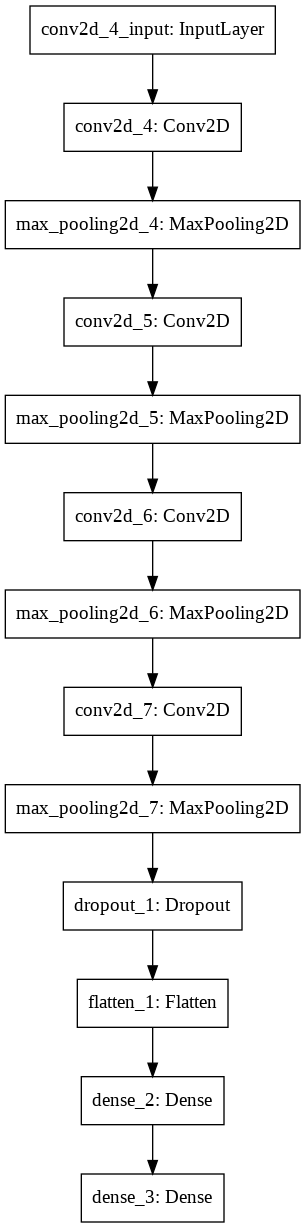

In [19]:
# Save weights & model-plot
save_classifier_weights()
save_classifier_model()
plot_model(classifier)

20/20 [==============================] - 0s 9ms/step - loss: 0.1269 - accuracy: 0.9510
Acuuracy on x_test data:  95.09803921568627 



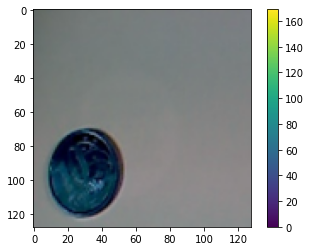

y_test:  1
y_test_predict:  1 



In [9]:
# Load model and check accuracy on x_test
from keras.models import load_model

model_loaded = load_model('/content/drive/My Drive/Coins Detector - Keras/Brazilian_coins_detector_model.h5')
model_loaded.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

model_loaded.evaluate(x_test, y_test)
label_correct, label_predict = test_classifier(model_loaded, x_test, y_test)
show_pic(x_test, label_correct, label_predict, 8)